In [1]:
! conda install geopandas -qy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import zipfile
import requests
import os
import shutil

%matplotlib inline

from downloading_funcs import addr_shape, down_extract_zip
from supp_funcs import zoneConcentration, pointInZone
import lnks



# All requested packages already installed.
# packages in environment at /opt/conda:
#
geopandas                 0.3.0                    py36_0    conda-forge


In [2]:
#Load the BBL list
BBL12_17CSV = ['https://opendata.arcgis.com/datasets/82ab09c9541b4eb8ba4b537e131998ce_22.csv', 'https://opendata.arcgis.com/datasets/4c4d6b4defdf4561b737a594b6f2b0dd_23.csv',   'https://opendata.arcgis.com/datasets/d7aa6d3a3fdc42c4b354b9e90da443b7_1.csv',     'https://opendata.arcgis.com/datasets/a8434614d90e416b80fbdfe2cb2901d8_2.csv', 'https://opendata.arcgis.com/datasets/714d5f8b06914b8596b34b181439e702_36.csv',     'https://opendata.arcgis.com/datasets/c4368a66ce65455595a211d530facc54_3.csv',]

In [3]:
def data_pipeline(shapetype, bbl_links, supplement=None,
                 dex=None, ts_lst_range=None):
    #A pipeline for group_e dataframe operations
    
    
    #Test inputs --------------------------------------------------------------
    if supplement:
        assert isinstance(supplement, list)
    assert isinstance(bbl_links, list)
    if ts_lst_range:
        assert isinstance(ts_lst_range, list)
        assert len(ts_lst_range) == 2 #Must be list of format [start-yr, end-yr]
    
    #We'll need our addresspoints and our shapefile
    if not dex:
        dex = addr_shape(shapetype)
    
    #We need a list of time_unit_of_analysis
    if ts_lst_range:
        ts_lst = [x+(i/100) for i in range(1,13,1) for x in range(1980, 2025)]
        ts_lst = [x for x in ts_lst if 
                  x >= ts_lst_range[0] and x <= ts_lst_range[1]]
        ts_lst = sorted(ts_lst)
    if not ts_lst_range:
        ts_lst = [x+(i/100) for i in range(1,13,1) for x in range(2012, 2017)]
        ts_lst = sorted(ts_lst)
    
    #Now we need to stack our BBL data ----------------------------------------
    
    #Begin by forming an empty DF 
    bbl_df = pd.DataFrame()
    for i in bbl_links:
        bbl = pd.read_csv(i, encoding='utf-8', low_memory=False)
        col_len = len(bbl.columns)
        bbl_df = bbl_df.append(bbl)
        if len(bbl.columns) != col_len:
            print('Column Mismatch!')
        del bbl
        
    bbl_df.LICENSE_START_DATE      = pd.to_datetime(
        bbl_df.LICENSE_START_DATE)
    
    bbl_df.LICENSE_EXPIRATION_DATE = pd.to_datetime(
        bbl_df.LICENSE_EXPIRATION_DATE)
    
    bbl_df.LICENSE_ISSUE_DATE      = pd.to_datetime(
        bbl_df.LICENSE_ISSUE_DATE)

    
    bbl_df.sort_values('LICENSE_START_DATE')
        
    #Set up our time unit of analysis
    bbl_df['month']      = 0
    bbl_df['endMonth']   = 0
    bbl_df['issueMonth'] = 0
    
    bbl_df['month'] = bbl_df['LICENSE_START_DATE'].dt.year + (
        bbl_df['LICENSE_START_DATE'].dt.month/100
    )
    bbl_df['endMonth'] = bbl_df['LICENSE_EXPIRATION_DATE'].dt.year + (
        bbl_df['LICENSE_EXPIRATION_DATE'].dt.month/100
    )
    bbl_df['issueMonth'] = bbl_df['LICENSE_ISSUE_DATE'].dt.year + (
        bbl_df['LICENSE_ISSUE_DATE'].dt.month/100
    )
    bbl_df.endMonth.fillna(max(ts_lst))
    bbl_df['endMonth'][bbl_df['endMonth'] > max(ts_lst)] = max(ts_lst)
       
    #Sort on month
    bbl_df = bbl_df.dropna(subset=['month'])
    bbl_df = bbl_df.set_index(['MARADDRESSREPOSITORYID','month'])
    bbl_df = bbl_df.sort_index(ascending=True)
    bbl_df.reset_index(inplace=True)
    
        
    bbl_df = bbl_df[bbl_df['MARADDRESSREPOSITORYID'] >= 0]
        
    bbl_df = bbl_df.dropna(subset=['LICENSESTATUS', 'issueMonth', 'endMonth',
                                   'MARADDRESSREPOSITORYID','month', 
                                   'LONGITUDE', 'LATITUDE'
                                  ])
    
    #Now that we have the BBL data, let's create our flag and points data -----
    
    #This is the addresspoints, passed from the dex param
    addr_df = dex[0]
    
    #Zip the latlongs
    addr_df['geometry'] = [
        Point(xy) for xy in zip(
            addr_df.LONGITUDE.apply(float), addr_df.LATITUDE.apply(float)
        )
    ]
    
    addr_df['Points']   = addr_df['geometry'] #Duplicate, so raw retains points
    
    addr_df['dummy_counter'] = 1 #Always one, always dropped before export
    
    crs='EPSG:4326' #Convenience assignment of crs
    
    #Now we're stacking for each month ----------------------------------------
    
    out_gdf = pd.DataFrame() #Empty storage df

    for i in ts_lst[:2]: #iterate through the list of months
                
        #dex[1] is the designated shapefile passed from the dex param, 
        #and should match the shapetype defined in that param
        
        #Copy of the dex[1] shapefile
        shp_gdf = dex[1]
        
        #Active BBL in month i
        bbl_df['inRange'] = 0
        bbl_df['inRange'][(bbl_df.endMonth > i) & (bbl_df.month <= i)] = 1
        
        #Issued BBL in month i
        bbl_df['isuFlag'] = 0
        bbl_df['isuFlag'][bbl_df.issueMonth == i] = 1
        
        #Merge BBL and MAR datasets -------------------------------------------
        addr    = pd.merge(addr_df, bbl_df, how='left', 
                        left_on='ADDRESS_ID', right_on='MARADDRESSREPOSITORYID')
        addr    = gpd.GeoDataFrame(addr, crs=crs, geometry=addr.geometry)
        
        
        addr.crs = shp_gdf.crs
        raw     = gpd.sjoin(shp_gdf, addr, how='left', op='intersects')
        
        #A simple percent of buildings with active flags per shape,
        #and call it a 'utilization index'
        numer = raw.groupby('NAME').sum()
        numer = numer.inRange
        denom = raw.groupby('NAME').sum()
        denom = denom.dummy_counter
        issue = raw.groupby('NAME').sum()
        issue = issue.isuFlag
        
        flags = []
        
        utl_inx           = pd.DataFrame(numer/denom)
        
        utl_inx.columns   = [
            'Util_Indx_BBL'
        ]
        flags.append(utl_inx)
        
        #This is number of buildings with an active BBL in month i
        bbl_count         = pd.DataFrame(numer)
        
        bbl_count.columns = [
            'countBBL'
        ]
        flags.append(bbl_count)
        
        #This is number of buildings that were issued a BBL in month i
        isu_count         = pd.DataFrame(issue)
        isu_count.columns = [
            'countIssued'
        ]
        flags.append(isu_count)
        
        for flag in flags:
            flag.crs = shp_gdf.crs

            shp_gdf = shp_gdf.merge(flag,
                                    how="left", left_on='NAME', right_index=True)
        shp_gdf['month'] = i
        
        #Head will be the list of retained columns
        head = ['NAME', 'Util_Indx_BBL',
               'countBBL', 'countIssued',
               'month', 'geometry']
        shp_gdf = shp_gdf[head]
        
        
        if supplement: #this is where your code will be fed into the pipeline.
            for supp_func in supplement:
                if len(supp_func) == 2:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1])
                if len(supp_func) == 3:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1],
                                          supp_func[2])
                if len(supp_func) == 4:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1],
                                          supp_func[2], supp_func[3])
                
        
        out_gdf = out_gdf.append(shp_gdf) #This does the stacking
        print('Merged month:', i)
        del shp_gdf, addr, utl_inx #Save me some memory please!
    
    #Can't have strings in our matrix
    out_gdf = pd.get_dummies(out_gdf, columns=['NAME'])
    out_gdf = out_gdf.drop('geometry', axis=1)
    
    out_gdf.to_csv('./data/' + shapetype + '_out.csv') #Save
    
    return [bbl_df, addr_df, out_gdf, raw] #Remove this later, for testing now
        

In [4]:
dex = addr_shape('anc')

In [5]:
def metro_prox(shp_gdf, raw, bufr=None):
    #Flag properties within distance "bufr" of metro stations
    
    if not bufr:
        bufr = 1/250 #Hard to say what a good buffer is.
    
    assert isinstance(bufr, float) #buffer must be float!
    
    #Frame up the metro buffer shapes
    metro = down_extract_zip(
    'https://opendata.arcgis.com/datasets/54018b7f06b943f2af278bbe415df1de_52.zip'
    )
    metro          = gpd.read_file(metro, crs=shp_gdf.crs)
    metro.geometry = metro.geometry.buffer(bufr)
    metro['bymet'] = 1
    metro.drop(['NAME'], axis=1, inplace=True)
    
    #Frame up the raw address points data
    pointy         = raw[['NAME', 'Points', 'dummy_counter']]
    pointy         = gpd.GeoDataFrame(pointy, crs=metro.crs, 
                                      geometry=pointy.Points)
    pointy         = gpd.sjoin(pointy, metro, 
                               how='left', op='intersects')
    
    denom = pointy.groupby('NAME').sum()
    denom = denom.dummy_counter
    
    numer = pointy.groupby('NAME').sum()
    numer = numer.bymet
    
    pct_metro_coverage    = pd.DataFrame(numer/denom)
        
    pct_metro_coverage.columns   = [
        'pct_metro_coverage'
    ]
    
    pct_metro_coverage.fillna(0, inplace=True)
    
    pct_metro_coverage.crs = pointy.crs
    shp_gdf = shp_gdf.merge(pct_metro_coverage,
                        how="left", left_on='NAME', right_index=True)
    return shp_gdf

In [6]:
#sets0-address df, 

In [7]:
#sets[2] #Our number of rows equals our number of shapes * number of months

In [8]:
cz1217 = ['https://opendata.arcgis.com/datasets/9cbe8553d4e2456ab6c140d83c7e83e0_15.csv', 'https://opendata.arcgis.com/datasets/3d49e06d51984fa2b68f21eed21eba1f_14.csv', 'https://opendata.arcgis.com/datasets/54b57e15f6944af8b413a5e4f88b070c_13.csv', 'https://opendata.arcgis.com/datasets/b3283607f9b74457aff420081eec3190_29.csv', 'https://opendata.arcgis.com/datasets/2dc1a7dbb705471eb38af39acfa16238_28.csv', 'https://opendata.arcgis.com/datasets/585c8c3ef58c4f1ab1ddf1c759b3a8bd_39.csv']

In [9]:
constr12 = pd.read_csv('https://opendata.arcgis.com/datasets/9cbe8553d4e2456ab6c140d83c7e83e0_15.csv')
constr13 = pd.read_csv('https://opendata.arcgis.com/datasets/3d49e06d51984fa2b68f21eed21eba1f_14.csv')
constr14 = pd.read_csv('https://opendata.arcgis.com/datasets/54b57e15f6944af8b413a5e4f88b070c_13.csv')
constr15 = pd.read_csv('https://opendata.arcgis.com/datasets/b3283607f9b74457aff420081eec3190_29.csv')
constr16 = pd.read_csv('https://opendata.arcgis.com/datasets/2dc1a7dbb705471eb38af39acfa16238_28.csv')
constr17 = pd.read_csv('https://opendata.arcgis.com/datasets/585c8c3ef58c4f1ab1ddf1c759b3a8bd_39.csv')
constr12_17 = pd.concat([constr12, constr13, constr14, constr15, constr16, constr17], axis=0, ignore_index=True)

In [10]:
constr12_17.head().T

,0,1,2,3,4
X,-77.0227,-77.0172,-77.0403,-77.0159,-77.047
Y,38.899,38.8776,38.8985,38.901,38.9049
OBJECTID,29723060,29741233,29742277,29744654,29747857
APPLICATIONDATE,2007-02-07T00:00:00.000Z,2009-02-25T09:13:49.000Z,2009-06-11T11:40:35.000Z,2009-08-14T17:05:20.000Z,2010-07-20T14:41:48.000Z
ISEXCAVATION,F,T,F,F,F
ISFIXTURE,F,F,F,T,T
ISPAVING,F,F,F,F,F
ISLANDSCAPING,F,F,F,F,F
ISPROJECTIONS,F,F,F,F,F
ISPSRENTAL,T,F,T,F,F


In [11]:
constr12_17.columns

Index(['X', 'Y', 'OBJECTID', 'APPLICATIONDATE', 'ISEXCAVATION', 'ISFIXTURE',
       'ISPAVING', 'ISLANDSCAPING', 'ISPROJECTIONS', 'ISPSRENTAL',
       'TRACKINGNUMBER', 'PERMITNUMBER', 'INTAKEDATE', 'ISSUEDATE',
       'EFFECTIVEDATE', 'EXPIRATIONDATE', 'XCOORD', 'YCOORD', 'STATUS',
       'WLFULLADDRESS', 'PERMITTEENAME', 'OWNERNAME', 'CONTRACTORNAME',
       'WORKDETAIL', 'READYFORREVIEWDATE', 'APPLICANTCOMPANYNAME', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')

In [12]:
constr12_17.shape

(78526, 28)

In [13]:
constr12_17['effective_date'] = pd.to_datetime(constr12_17['EFFECTIVEDATE'])
constr12_17['expire_date'] = pd.to_datetime(constr12_17['EXPIRATIONDATE'])
permit_length = (constr12_17.expire_date - constr12_17.effective_date)
print(permit_length)

0       120 days 00:00:00
1        98 days 00:00:00
2       365 days 00:00:00
3        18 days 00:00:00
4       364 days 00:00:00
5       364 days 00:00:00
6       364 days 00:00:00
7       364 days 00:00:00
8       307 days 10:26:07
9       365 days 00:00:00
10      364 days 00:00:00
11      364 days 00:00:00
12      179 days 00:00:00
13      364 days 00:00:00
14      364 days 00:00:00
15      364 days 00:00:00
16      306 days 00:00:00
17      364 days 00:00:00
18       77 days 00:00:00
19       61 days 00:00:00
20      306 days 00:00:00
21      364 days 00:00:00
22      193 days 00:00:00
23      179 days 00:00:00
24       80 days 00:00:00
25       80 days 00:00:00
26       80 days 00:00:00
27      365 days 00:00:00
28      364 days 00:00:00
29       67 days 00:00:00
               ...       
78496    59 days 00:00:00
78497    59 days 00:00:00
78498    59 days 00:00:00
78499   130 days 00:00:00
78500    59 days 00:00:00
78501    59 days 00:00:00
78502    59 days 00:00:00
78503    59 

In [14]:
permits = constr12_17[(constr12_17['STATUS']=='Permit Expired') | 
                (constr12_17['STATUS']=='Approved (Pending Payment)') |
                (constr12_17['STATUS']=='Issued') |
                (constr12_17['STATUS']=='Assigned')]
print(permits.STATUS.unique())

['Permit Expired' 'Issued' 'Assigned' 'Approved (Pending Payment)']


In [15]:
permits.sort_values('effective_date')
permits['month'] = 0
permits['month'] = 0

permits['month'] = permits['effective_date'].dt.year + (permits['effective_date'].dt.month/100)
permits['endmonth'] = permits['expire_date'].dt.year + (permits['expire_date'].dt.month/100)

permits = permits.set_index(['month'])
permits = permits.sort_index(ascending=True)
permits.reset_index(inplace=True)

permits = permits.dropna(subset=['STATUS', 'endmonth', 'month', 'LONGITUDE', 'LATITUDE'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [16]:
! wget https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson -O census2012

--2017-11-19 18:28:39--  https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 34.235.70.5, 52.22.192.109
Connecting to opendata.arcgis.com (opendata.arcgis.com)|34.235.70.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘census2012’

census2012              [ <=>                ]   1.71M  --.-KB/s    in 0.04s   

2017-11-19 18:28:39 (42.8 MB/s) - ‘census2012’ saved [1794478]



In [17]:
import geopandas as gpd
import os
census = gpd.read_file('census2012')

In [18]:
census.columns

Index(['OBJECTID', 'TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003',
       'P0010004', 'P0010005', 'P0010006', 'P0010007', 'P0010008', 'OP000001',
       'OP000002', 'OP000003', 'OP000004', 'P0020002', 'P0020005', 'P0020006',
       'P0020007', 'P0020008', 'P0020009', 'P0020010', 'OP00005', 'OP00006',
       'OP00007', 'OP00008', 'P0030001', 'P0030003', 'P0030004', 'P0030005',
       'P0030006', 'P0030007', 'P0030008', 'OP00009', 'OP00010', 'OP00011',
       'OP00012', 'P0040002', 'P0040005', 'P0040006', 'P0040007', 'P0040008',
       'P0040009', 'P0040010', 'OP000013', 'OP000014', 'OP000015', 'OP000016',
       'H0010001', 'H0010002', 'H0010003', 'ACRES', 'SQ_MILES', 'Shape_Length',
       'Shape_Area', 'FAGI_TOTAL_2010', 'FAGI_MEDIAN_2010', 'FAGI_TOTAL_2013',
       'FAGI_MEDIAN_2013', 'geometry'],
      dtype='object')

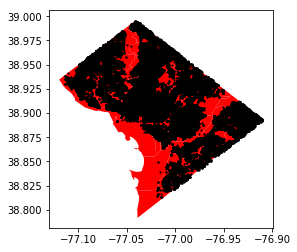

In [19]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(permits.LONGITUDE.apply(float), permits.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(permits, crs=crs, geometry=geometry)
fig, ax = plt.subplots()
census.plot(ax=ax, color='red')
points.plot(ax=ax, color='black', marker='.', markersize=5)
ax.set_aspect('equal')

In [20]:
geo_constr = gpd.sjoin(census, points, how='left', op='intersects')
geo_constr.head()

,OBJECTID_left,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,OWNERNAME,CONTRACTORNAME,WORKDETAIL,READYFORREVIEWDATE,APPLICANTCOMPANYNAME,LATITUDE,LONGITUDE,effective_date,expire_date,endmonth
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Greg Calderon,Gregory Calderon,Up to 3 Utility Test Holes to identify the dep...,2016-10-25T07:33:37.000Z,NaN,38.960390,-77.085981,2016-12-07,2017-02-07,2017.02
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Lightower Lightower,LIGHTOWER LIGHTOWER,Excavate to install (2) -3' x 2' x 3' Lightowe...,2015-07-02T15:20:55.000Z,NaN,38.960464,-77.086147,2015-09-08,2015-11-06,2015.11
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,DCWater/OPS,NaN,Repair sewer main in sidewalk.,2015-01-26T08:44:22.000Z,DCWater/OPS,38.960782,-77.085733,2015-01-26,2015-03-26,2015.03
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,DISTRICT DEPARTMENT OF TRANSPORTATION,NaN,The Tenlytown Historical Society will clean th...,2012-10-09T16:11:46.000Z,NaN,38.960782,-77.085733,2012-10-15,2012-11-06,2012.11
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Potomac Electric Power Company,NaN,WR#3486881 CUT#40139-REPLACE MANHOLE FRAME AND...,2015-08-19T15:24:41.000Z,Potomac Electric Power Company,38.960782,-77.085733,2015-08-19,2015-10-01,2015.10


In [21]:
geo_constr.geometry.head()

0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
Name: geometry, dtype: object

In [22]:
Contruct2HouseRatio = pd.DataFrame(geo_constr.TRACT.value_counts()*100000/geo_constr.H0010002.sum())
print(Contruct2HouseRatio)

           TRACT
010700  1.491623
010600  1.442746
005800  1.057839
000100  0.950484
001001  0.944374
007200  0.929537
004400  0.925173
011100  0.865822
000801  0.816072
000901  0.757594
010100  0.740138
003200  0.740138
010200  0.688643
004801  0.679915
000202  0.652858
004600  0.651985
005500  0.643257
002502  0.638893
010800  0.617946
001100  0.612709
008803  0.596998
002900  0.585652
008802  0.584779
009301  0.581288
003301  0.571687
002400  0.566450
001500  0.562086
009400  0.542012
003800  0.542012
000600  0.540266
...          ...
007409  0.157105
009904  0.152741
009906  0.150995
007709  0.150122
002001  0.137903
011000  0.137030
002202  0.133539
009507  0.129175
009804  0.127429
007404  0.123938
009802  0.113465
007408  0.112592
009801  0.110846
010900  0.110846
007708  0.109101
009903  0.109101
007406  0.103864
007605  0.103864
009000  0.102118
009811  0.097754
009810  0.089026
001803  0.088153
009700  0.084662
009907  0.081171
007403  0.074188
007301  0.066333
000702  0.0619

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


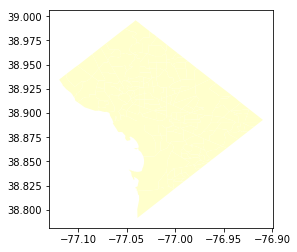

In [23]:
Contruct2HouseRatio.columns = ['Contruct2HouseRatio']
tracts_permits = census.merge(Contruct2HouseRatio, how="left", left_on='OBJECTID', right_index=True)
tracts_permits.plot(column='Contruct2HouseRatio', cmap='YlOrRd')